   Embarazos reportados     n     %
0                     0  1011  81.5
1                     1   190  15.3
2                     2    32   2.6
3                     3     6   0.5
4                     4     2   0.2


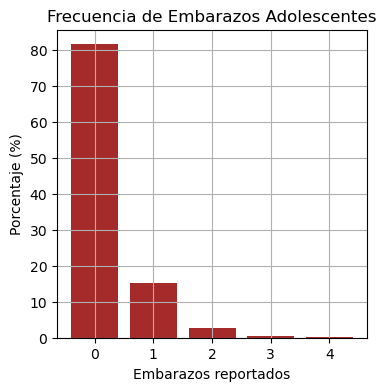

In [43]:
# ==========================================================
# Maestría en Ciencia y Análisis de Datos
# Universidad Mayor de San Andrés
# ----------------------------------------------------------
#   Modelos lineales y modelos lineales generalizados
# ----------------------------------------------------------
#        Rolando Gonzales Martinez, Julio 2024
# ==========================================================
# Modelos lineales generalizados: motivación
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data = {
    'Embarazos reportados': [0, 1, 2, 3, 4],
    'n': [1011, 190, 32, 6, 2],
    '%': [81.5, 15.3, 2.6, 0.5, 0.2]
}

df = pd.DataFrame(data)
print(df)

# Gráfico de barras
plt.figure(figsize=(4, 4))
plt.bar(df['Embarazos reportados'], df['%'], color='brown')
plt.title('Frecuencia de Embarazos Adolescentes')
plt.xlabel('Embarazos reportados')
plt.ylabel('Porcentaje (%)')
plt.xticks(df['Embarazos reportados'])
plt.grid(True)
plt.show()

In [ ]:
# Cargar el conjunto de datos:
url = "https://raw.githubusercontent.com/rogon666/UMSA/main/MLMLG/datos/crimenes.csv"
datos = pd.read_csv(url)
print(datos.head())
'''
Ejemplo de motivación: crimenes en instituciones postsecundarias Estados Unidos:
matriculados = personas matriculadas
tipo = colegio (C) o universidad (U)
nv = número de delitos violentos cometidos en la universidad o colegio
nvrate = número de delitos violentos por cada 1000 estudiantes
matriculados = personas matriculadas, en miles
region = región del país (C = Central, 
                         MO = Medio Oeste, 
                         NE = Noreste, 
                         SE = Sudeste, 
                         SO = Suroeste y 
                         O = Oeste)
Fuente: US Department of Education
'''

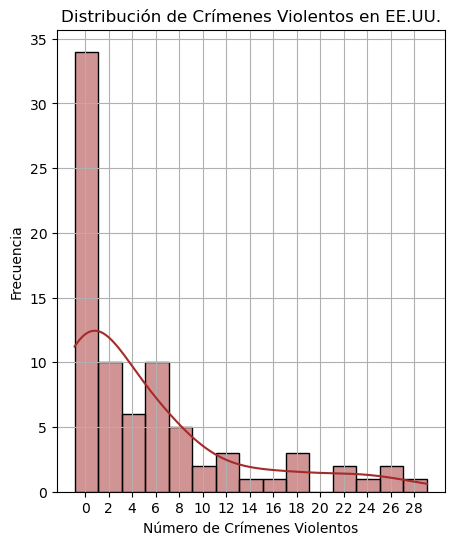

In [38]:
# Plot the distribution of the number of violent crimes (nv)
plt.figure(figsize=(5, 6))
hist = sns.histplot(datos['nv'], bins=15, kde=True, color='brown')
plt.title('Distribución de Crímenes Violentos en EE.UU.')
plt.xlabel('Número de Crímenes Violentos')
plt.ylabel('Frecuencia')
plt.grid(True)
# Ajustando las marcas de los ticks en el eje x al centro de las barras:
bin_edges = hist.patches[0].get_bbox().bounds
bin_centers = 0.45 * (hist.patches[0].get_width()) + np.array([p.get_x() for p in hist.patches])
plt.xticks(bin_centers, [f'{int(b)}' for b in bin_centers])
plt.show()